In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from lightgbm import LGBMClassifier, LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [36]:
df = pd.read_excel('dataset_final.xlsx')


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3983 entries, 0 to 3982
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   TANGGAL  3983 non-null   datetime64[ns]
 1   TN       3983 non-null   float64       
 2   TX       3983 non-null   float64       
 3   TAVG     3983 non-null   float64       
 4   RH_AVG   3983 non-null   float64       
 5   RR       3983 non-null   float64       
 6   SS       3983 non-null   float64       
 7   FF_X     3983 non-null   int64         
 8   DDD_X    3983 non-null   int64         
 9   FF_AVG   3983 non-null   int64         
 10  DDD_CAR  3983 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(4)
memory usage: 342.4 KB


In [38]:
# Feature Engineering 

def create_advanced_features(df):
    """
    Membuat fitur-fitur advanced untuk prediksi curah hujan
    """
    df = df.copy()
    
    print("Creating advanced features...")
    
    df['month'] = df['TANGGAL'].dt.month
    df['day'] = df['TANGGAL'].dt.day
    df['dayofyear'] = df['TANGGAL'].dt.dayofyear
    df['week'] = df['TANGGAL'].dt.isocalendar().week
    df['quarter'] = df['TANGGAL'].dt.quarter
    df['dayofweek'] = df['TANGGAL'].dt.dayofweek
    
    # Cyclical encoding
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
    
    # Musim hujan Indonesia
    df['is_rainy_season'] = df['month'].apply(lambda x: 1 if x in [11, 12, 1, 2, 3] else 0)
    
   #Lag features
    for i in range(1, 8):
        df[f'RR_lag{i}'] = df['RR'].shift(i)
    
    for col in ['TAVG', 'RH_AVG', 'FF_AVG', 'SS']:
        df[f'{col}_lag1'] = df[col].shift(1)
        df[f'{col}_lag2'] = df[col].shift(2)
        df[f'{col}_lag3'] = df[col].shift(3)
    
    # Rolling Statistic
    windows = [3, 7, 14, 30]
    
    for window in windows:
        df[f'RR_mean{window}'] = df['RR'].rolling(window=window).mean()
        df[f'RR_max{window}'] = df['RR'].rolling(window=window).max()
        df[f'RR_min{window}'] = df['RR'].rolling(window=window).min()
        df[f'RR_std{window}'] = df['RR'].rolling(window=window).std()
        df[f'RR_sum{window}'] = df['RR'].rolling(window=window).sum()
        
        df[f'TAVG_mean{window}'] = df['TAVG'].rolling(window=window).mean()
        df[f'TAVG_std{window}'] = df['TAVG'].rolling(window=window).std()
        
        df[f'RH_AVG_mean{window}'] = df['RH_AVG'].rolling(window=window).mean()
        df[f'RH_AVG_std{window}'] = df['RH_AVG'].rolling(window=window).std()
    
    # Trend Features
    df['consecutive_rainy'] = (df['RR'] > 0).groupby((df['RR'] == 0).cumsum()).cumsum()
    df['consecutive_dry'] = (df['RR'] == 0).groupby((df['RR'] > 0).cumsum()).cumsum()
    
    df['rainy_days_7d'] = df['RR'].rolling(window=7).apply(lambda x: (x > 0).sum())
    df['rainy_days_14d'] = df['RR'].rolling(window=14).apply(lambda x: (x > 0).sum())
    df['rainy_days_30d'] = df['RR'].rolling(window=30).apply(lambda x: (x > 0).sum())
    
    df['is_rainy_yesterday'] = (df['RR_lag1'] > 0).astype(int)
    df['is_rainy_2days_ago'] = (df['RR_lag2'] > 0).astype(int)
    
    # Interaction Features
    df['temp_humidity'] = df['TAVG'] * df['RH_AVG']
    df['temp_range'] = df['TX'] - df['TN']
    df['sunshine_humidity'] = df['SS'] * (100 - df['RH_AVG'])
    df['wind_humidity'] = df['FF_AVG'] * df['RH_AVG']
    df['temp_wind'] = df['TAVG'] * df['FF_AVG']
    
    # EXPONENTIAL MOVING AVERAGE
    df['RR_ema3'] = df['RR'].ewm(span=3, adjust=False).mean()
    df['RR_ema7'] = df['RR'].ewm(span=7, adjust=False).mean()
    df['RH_AVG_ema7'] = df['RH_AVG'].ewm(span=7, adjust=False).mean()
    
    # Rate of change 
    df['RR_change'] = df['RR'].diff()
    df['TAVG_change'] = df['TAVG'].diff()
    df['RH_AVG_change'] = df['RH_AVG'].diff()
    
    # Percentile Features
    df['RR_percentile_30d'] = df['RR'].rolling(window=30).apply(
        lambda x: pd.Series(x).rank(pct=True).iloc[-1] if len(x) > 0 else np.nan
    )
    
    print(f"Created {len(df.columns)} features total")
    
    return df

In [39]:
#Pisahkan fitur & target
exclude_cols = ['TANGGAL', 'RR']
feature_cols = [col for col in df.columns if col not in exclude_cols]

X = df[feature_cols]
y = df['RR']

print(f"Total features: {len(feature_cols)}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print(f"🔹 Train size: {len(X_train)}, Test size: {len(X_test)}")

results = {}

Total features: 9
🔹 Train size: 3186, Test size: 797


In [40]:
df = create_advanced_features(df)
df_clean = df.dropna().reset_index(drop=True)

print(f"\nData shape after feature engineering: {df_clean.shape}")

Creating advanced features...
Created 96 features total

Data shape after feature engineering: (3954, 96)


In [41]:
print("SEARCHING FOR OPTIMAL THRESHOLDS...")

# Test all threshold combination
rain_thresholds = [0.1, 0.5, 1.0]  # mm
prob_thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

best_mae = float('inf')
best_config = {}
results_list = []

for RAIN_THRESHOLD in rain_thresholds:
    print(f"\nTest RAIN_THRESHOLD = {RAIN_THRESHOLD} mm")
    
    # Create target untuk klasifikasi
    df_clean['is_rain'] = (df_clean['RR'] > RAIN_THRESHOLD).astype(int)
    
    # Pisahkan fitur & target
    exclude_cols = ['TANGGAL', 'RR', 'is_rain']
    feature_cols = [col for col in df_clean.columns if col not in exclude_cols]
    
    X = df_clean[feature_cols]
    y_regression = df_clean['RR']
    y_classification = df_clean['is_rain']
    
    # Split data
    X_train, X_test, y_reg_train, y_reg_test, y_cls_train, y_cls_test = train_test_split(
        X, y_regression, y_classification, test_size=0.2, shuffle=False
    )
    
    # ===== TRAIN CLASSIFIER =====
    classifier = LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=7,
        num_leaves=50,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight='balanced',
        random_state=42,
        verbose=-1
    )
    
    classifier.fit(X_train, y_cls_train)
    rain_probability = classifier.predict_proba(X_test)[:, 1]
    
    # ===== TRAIN REGRESSOR (hanya pada hari hujan) =====
    rain_mask_train = y_reg_train > RAIN_THRESHOLD
    X_train_rain = X_train[rain_mask_train]
    y_train_rain = y_reg_train[rain_mask_train]
    
    regressor = GradientBoostingRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=7,
        min_samples_split=5,
        min_samples_leaf=2,
        subsample=0.8,
        loss='huber',
        alpha=0.9,
        random_state=42
    )
    
    regressor.fit(X_train_rain, y_train_rain)
    
    # ===== TEST BERBAGAI PROBABILITY THRESHOLD =====
    for PROB_THRESHOLD in prob_thresholds:
        # Two-stage prediction
        y_pred_final = np.zeros(len(X_test))
        
        for i in range(len(X_test)):
            if rain_probability[i] > PROB_THRESHOLD:
                rain_amount = regressor.predict(X_test.iloc[[i]])[0]
                y_pred_final[i] = max(0, rain_amount)
            else:
                y_pred_final[i] = 0.0
        
        # Evaluasi
        mae = mean_absolute_error(y_reg_test, y_pred_final)
        rmse = np.sqrt(mean_squared_error(y_reg_test, y_pred_final))
        r2 = r2_score(y_reg_test, y_pred_final)
        
        # Simpan hasil
        results_list.append({
            'rain_threshold': RAIN_THRESHOLD,
            'prob_threshold': PROB_THRESHOLD,
            'mae': mae,
            'rmse': rmse,
            'r2': r2
        })
        
        print(f"   Prob={PROB_THRESHOLD:.1f} → MAE={mae:.3f}, RMSE={rmse:.3f}, R²={r2:.3f}")
        
        # Update best config
        if mae < best_mae:
            best_mae = mae
            best_config = {
                'rain_threshold': RAIN_THRESHOLD,
                'prob_threshold': PROB_THRESHOLD,
                'mae': mae,
                'rmse': rmse,
                'r2': r2,
                'classifier': classifier,
                'regressor': regressor,
                'X_test': X_test,
                'y_reg_test': y_reg_test,
                'y_cls_test': y_cls_test,
                'rain_probability': rain_probability,
                'y_pred_final': y_pred_final,
                'feature_cols': feature_cols,
                'X': X
            }

SEARCHING FOR OPTIMAL THRESHOLDS...

Test RAIN_THRESHOLD = 0.1 mm
   Prob=0.3 → MAE=0.667, RMSE=1.804, R²=0.985
   Prob=0.4 → MAE=0.667, RMSE=1.804, R²=0.985
   Prob=0.5 → MAE=0.667, RMSE=1.804, R²=0.985
   Prob=0.6 → MAE=0.667, RMSE=1.804, R²=0.985
   Prob=0.7 → MAE=0.667, RMSE=1.804, R²=0.985

Test RAIN_THRESHOLD = 0.5 mm
   Prob=0.3 → MAE=0.650, RMSE=1.623, R²=0.988
   Prob=0.4 → MAE=0.650, RMSE=1.623, R²=0.988
   Prob=0.5 → MAE=0.650, RMSE=1.623, R²=0.988
   Prob=0.6 → MAE=0.650, RMSE=1.623, R²=0.988
   Prob=0.7 → MAE=0.650, RMSE=1.623, R²=0.988

Test RAIN_THRESHOLD = 1.0 mm
   Prob=0.3 → MAE=0.677, RMSE=1.732, R²=0.986
   Prob=0.4 → MAE=0.677, RMSE=1.732, R²=0.986
   Prob=0.5 → MAE=0.679, RMSE=1.734, R²=0.986
   Prob=0.6 → MAE=0.679, RMSE=1.734, R²=0.986
   Prob=0.7 → MAE=0.680, RMSE=1.734, R²=0.986


In [42]:
print("BEST CONFIGURATION FOUND!")
print(f"Rain Threshold      : {best_config['rain_threshold']} mm")
print(f"Probability Threshold: {best_config['prob_threshold']}")
print(f"MAE                 : {best_config['mae']:.3f} mm")
print(f"RMSE                : {best_config['rmse']:.3f} mm")
print(f"R²                  : {best_config['r2']:.3f}")

# DataFrame hasil semua kombinasi
results_df = pd.DataFrame(results_list).sort_values('mae')
print("\nTop 10 Configurations:")
print(results_df.head(10).to_string(index=False))

BEST CONFIGURATION FOUND!
Rain Threshold      : 0.5 mm
Probability Threshold: 0.3
MAE                 : 0.650 mm
RMSE                : 1.623 mm
R²                  : 0.988

Top 10 Configurations:
 rain_threshold  prob_threshold      mae     rmse       r2
            0.5             0.4 0.649729 1.622794 0.988090
            0.5             0.5 0.649729 1.622794 0.988090
            0.5             0.3 0.649729 1.622794 0.988090
            0.5             0.6 0.649729 1.622794 0.988090
            0.5             0.7 0.649729 1.622794 0.988090
            0.1             0.7 0.666743 1.803807 0.985284
            0.1             0.4 0.667313 1.803915 0.985283
            0.1             0.5 0.667313 1.803915 0.985283
            0.1             0.3 0.667313 1.803915 0.985283
            0.1             0.6 0.667418 1.803919 0.985282


In [43]:
classifier = best_config['classifier']
regressor = best_config['regressor']
X_test = best_config['X_test']
y_reg_test = best_config['y_reg_test']
y_cls_test = best_config['y_cls_test']
rain_probability = best_config['rain_probability']
y_pred_final = best_config['y_pred_final']
feature_cols = best_config['feature_cols']
RAIN_THRESHOLD = best_config['rain_threshold']
PROB_THRESHOLD = best_config['prob_threshold']

# Classification metrics
y_cls_pred = (rain_probability > PROB_THRESHOLD).astype(int)
cls_accuracy = accuracy_score(y_cls_test, y_cls_pred)
f1 = f1_score(y_cls_test, y_cls_pred)

print("\nClassification Performance:")
print(f"   Accuracy: {cls_accuracy:.3f}")
print(f"   F1-Score: {f1:.3f}")
print("\n" + classification_report(y_cls_test, y_cls_pred, target_names=['No Rain', 'Rain']))

# Confusion Matrix
cm = confusion_matrix(y_cls_test, y_cls_pred)
print("Confusion Matrix:")
print(f"                Predicted")
print(f"              No Rain  Rain")
print(f"Actual No Rain  {cm[0,0]:5d}  {cm[0,1]:5d}")
print(f"       Rain     {cm[1,0]:5d}  {cm[1,1]:5d}")

# Performance pada hari hujan saja
rain_mask_test = y_reg_test > RAIN_THRESHOLD
if rain_mask_test.sum() > 0:
    mae_rainy = mean_absolute_error(y_reg_test[rain_mask_test], y_pred_final[rain_mask_test])
    rmse_rainy = np.sqrt(mean_squared_error(y_reg_test[rain_mask_test], y_pred_final[rain_mask_test]))
    print(f"\nPerformance on RAINY days only ({rain_mask_test.sum()} days):")
    print(f"   MAE  : {mae_rainy:.3f} mm")
    print(f"   RMSE : {rmse_rainy:.3f} mm")


Classification Performance:
   Accuracy: 0.985
   F1-Score: 0.989

              precision    recall  f1-score   support

     No Rain       0.98      0.98      0.98       269
        Rain       0.99      0.99      0.99       522

    accuracy                           0.98       791
   macro avg       0.98      0.98      0.98       791
weighted avg       0.98      0.98      0.98       791

Confusion Matrix:
                Predicted
              No Rain  Rain
Actual No Rain    263      6
       Rain         6    516

Performance on RAINY days only (522 days):
   MAE  : 0.939 mm
   RMSE : 1.991 mm


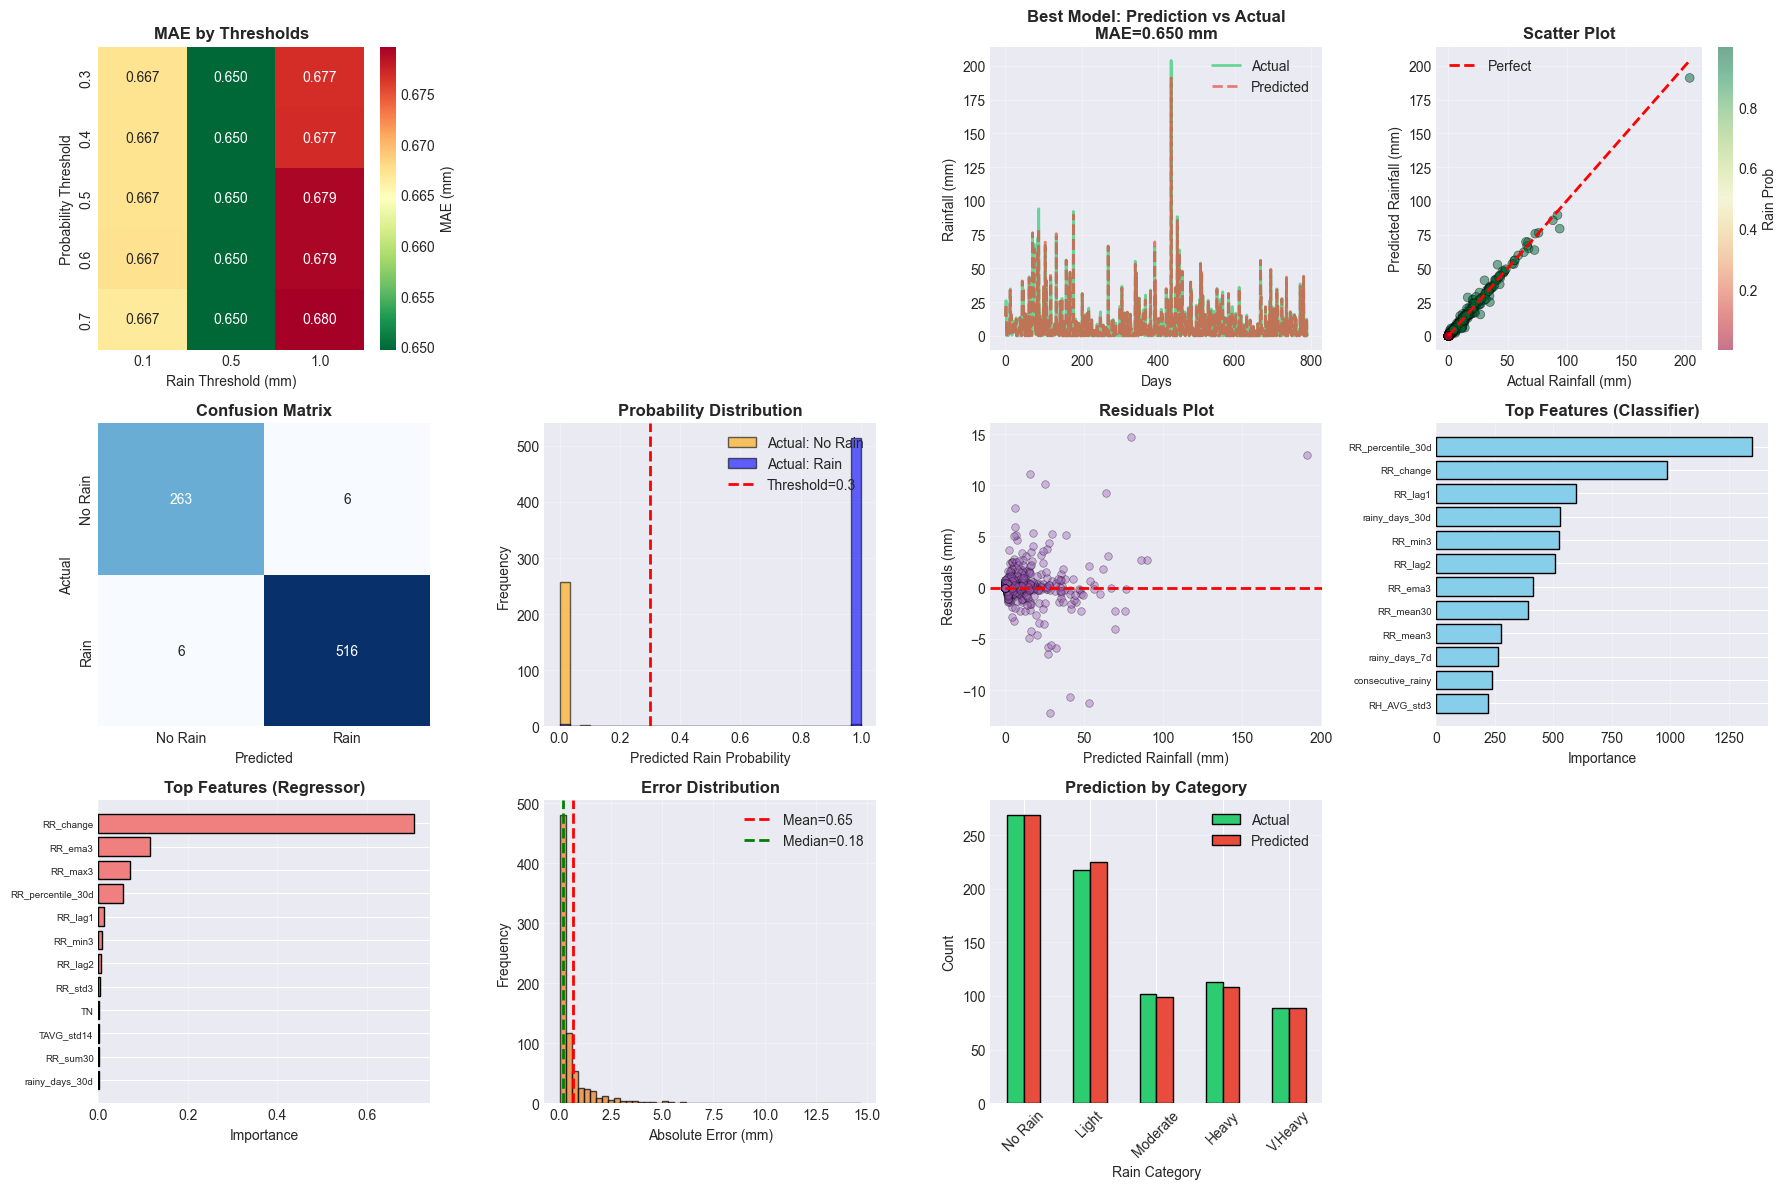

In [44]:
fig = plt.figure(figsize=(18, 12))

# Plot 1: MAE vs Thresholds Heatmap
plt.subplot(3, 4, 1)
pivot_mae = results_df.pivot(index='prob_threshold', columns='rain_threshold', values='mae')
sns.heatmap(pivot_mae, annot=True, fmt='.3f', cmap='RdYlGn_r', cbar_kws={'label': 'MAE (mm)'})
plt.title('MAE by Thresholds', fontweight='bold')
plt.xlabel('Rain Threshold (mm)')
plt.ylabel('Probability Threshold')


# Plot 2: Prediction vs Actual
plt.subplot(3, 4, 3)
plt.plot(y_reg_test.values, label='Actual', linewidth=2, alpha=0.7, color='#2ecc71')
plt.plot(y_pred_final, label='Predicted', linestyle='--', linewidth=2, alpha=0.7, color='#e74c3c')
plt.title(f'Best Model: Prediction vs Actual\nMAE={best_config["mae"]:.3f} mm', fontweight='bold')
plt.xlabel('Days')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Scatter Plot
plt.subplot(3, 4, 4)
scatter = plt.scatter(y_reg_test, y_pred_final, alpha=0.5, s=40, c=rain_probability, 
                     cmap='RdYlGn', edgecolors='k', linewidth=0.5)
plt.plot([0, y_reg_test.max()], [0, y_reg_test.max()], 'r--', lw=2, label='Perfect')
plt.xlabel('Actual Rainfall (mm)')
plt.ylabel('Predicted Rainfall (mm)')
plt.title('Scatter Plot', fontweight='bold')
plt.colorbar(scatter, label='Rain Prob')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Confusion Matrix
plt.subplot(3, 4, 5)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix', fontweight='bold')

# Plot 5: Rain Probability Distribution
plt.subplot(3, 4, 6)
plt.hist(rain_probability[y_cls_test == 0], bins=30, alpha=0.6, label='Actual: No Rain', color='orange', edgecolor='black')
plt.hist(rain_probability[y_cls_test == 1], bins=30, alpha=0.6, label='Actual: Rain', color='blue', edgecolor='black')
plt.axvline(x=PROB_THRESHOLD, color='r', linestyle='--', linewidth=2, label=f'Threshold={PROB_THRESHOLD}')
plt.xlabel('Predicted Rain Probability')
plt.ylabel('Frequency')
plt.title('Probability Distribution', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 6: Residuals
plt.subplot(3, 4, 7)
residuals = y_reg_test.values - y_pred_final
plt.scatter(y_pred_final, residuals, alpha=0.4, s=30, c='#9b59b6', edgecolors='k', linewidth=0.5)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Rainfall (mm)')
plt.ylabel('Residuals (mm)')
plt.title('Residuals Plot', fontweight='bold')
plt.grid(True, alpha=0.3)

# Plot 7: Feature Importance (Classifier)
plt.subplot(3, 4, 8)
cls_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': classifier.feature_importances_
}).sort_values('importance', ascending=False).head(12)
plt.barh(range(len(cls_importance)), cls_importance['importance'], color='skyblue', edgecolor='black')
plt.yticks(range(len(cls_importance)), cls_importance['feature'], fontsize=7)
plt.xlabel('Importance')
plt.title('Top Features (Classifier)', fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

# Plot 8: Feature Importance (Regressor)
plt.subplot(3, 4, 9)
reg_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': regressor.feature_importances_
}).sort_values('importance', ascending=False).head(12)
plt.barh(range(len(reg_importance)), reg_importance['importance'], color='lightcoral', edgecolor='black')
plt.yticks(range(len(reg_importance)), reg_importance['feature'], fontsize=7)
plt.xlabel('Importance')
plt.title('Top Features (Regressor)', fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

# Plot 10: Error Distribution
plt.subplot(3, 4, 10)
abs_errors = np.abs(residuals)
plt.hist(abs_errors, bins=50, edgecolor='black', alpha=0.7, color='#e67e22')
plt.xlabel('Absolute Error (mm)')
plt.ylabel('Frequency')
plt.title('Error Distribution', fontweight='bold')
plt.axvline(x=np.mean(abs_errors), color='r', linestyle='--', linewidth=2, label=f'Mean={np.mean(abs_errors):.2f}')
plt.axvline(x=np.median(abs_errors), color='g', linestyle='--', linewidth=2, label=f'Median={np.median(abs_errors):.2f}')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 11: Performance by Category
plt.subplot(3, 4, 11)
categories_bins = [-0.1, 0.5, 5, 10, 20, 100]
categories_labels = ['No Rain', 'Light', 'Moderate', 'Heavy', 'V.Heavy']
actual_cat = pd.cut(y_reg_test, bins=categories_bins, labels=categories_labels)
pred_cat = pd.cut(y_pred_final, bins=categories_bins, labels=categories_labels)

cat_df = pd.DataFrame({
    'Actual': actual_cat.value_counts().sort_index(),
    'Predicted': pred_cat.value_counts().sort_index()
})
cat_df.plot(kind='bar', ax=plt.gca(), color=['#2ecc71', '#e74c3c'], edgecolor='black')
plt.xlabel('Rain Category')
plt.ylabel('Count')
plt.title('Prediction by Category', fontweight='bold')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')


plt.tight_layout()
plt.show()

In [45]:

print("PREDIKSI CURAH HUJAN ESOK HARI")


X = best_config['X']
latest_data = X.iloc[-1:].copy()

# Stage 1: Prediksi probabilitas hujan
rain_prob_tomorrow = classifier.predict_proba(latest_data)[0, 1]
will_rain = rain_prob_tomorrow > PROB_THRESHOLD

print(f"Probabilitas Hujan: {rain_prob_tomorrow*100:.1f}%")
print(f"Threshold: {PROB_THRESHOLD*100:.0f}%")

if will_rain:
    # Stage 2: Prediksi intensitas
    predicted_rain = regressor.predict(latest_data)[0]
    predicted_rain = max(0, predicted_rain)
    
    print(f"\nPREDIKSI: AKAN HUJAN")
    print(f"Intensitas Prediksi: {predicted_rain:.2f} mm")
    
    # Confidence interval berdasarkan error historis
    std_error = np.std(y_reg_test[rain_mask_test] - y_pred_final[rain_mask_test])
    lower = max(0, predicted_rain - std_error)
    upper = predicted_rain + std_error
    print(f"📊 Range Prediksi: {lower:.2f} - {upper:.2f} mm")
    
    if predicted_rain < 1:
        status = "Hujan sangat ringan"
    elif predicted_rain < 5:
        status = "Hujan ringan"
    elif predicted_rain < 10:
        status = "Hujan sedang"
    elif predicted_rain < 20:
        status = "Hujan lebat"
    else:
        status = "Hujan sangat lebat"
    
    print(f"Status: {status}")
else:
    predicted_rain = 0.0
    print(f"\nPREDIKSI: TIDAK HUJAN")
    print(f"Intensitas Prediksi: {predicted_rain:.2f} mm")

print(f"\nModel Configuration:")
print(f"   Rain Threshold: {RAIN_THRESHOLD} mm")
print(f"   Probability Threshold: {PROB_THRESHOLD}")
print(f"   Model MAE: {best_config['mae']:.3f} mm")
print(f"   Model R²: {best_config['r2']:.3f}")


PREDIKSI CURAH HUJAN ESOK HARI
Probabilitas Hujan: 0.0%
Threshold: 30%

PREDIKSI: TIDAK HUJAN
Intensitas Prediksi: 0.00 mm

Model Configuration:
   Rain Threshold: 0.5 mm
   Probability Threshold: 0.3
   Model MAE: 0.650 mm
   Model R²: 0.988


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3983 entries, 0 to 3982
Data columns (total 96 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   TANGGAL             3983 non-null   datetime64[ns]
 1   TN                  3983 non-null   float64       
 2   TX                  3983 non-null   float64       
 3   TAVG                3983 non-null   float64       
 4   RH_AVG              3983 non-null   float64       
 5   RR                  3983 non-null   float64       
 6   SS                  3983 non-null   float64       
 7   FF_X                3983 non-null   int64         
 8   DDD_X               3983 non-null   int64         
 9   FF_AVG              3983 non-null   int64         
 10  DDD_CAR             3983 non-null   int64         
 11  month               3983 non-null   int32         
 12  day                 3983 non-null   int32         
 13  dayofyear           3983 non-null   int32       

In [47]:
new_df = df.to_excel('Test.xlsx')